# Binary Image Classification: Galaxy vs Star
This notebook trains a CNN to classify images as either galaxies or stars using **PyTorch**.

## 1. Import Libraries

In [3]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import time

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA device count:", torch.cuda.device_count())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Using device:", device)

# Common parameters
img_height = 64
img_width = 64
batch_size = 32
data_dir = "images"

PyTorch version: 2.7.1+cu118
CUDA available: True
CUDA device count: 1
Using device: cuda


## 2. Load and Prepare Data
Load images from the folder structure. PyTorch will use folder names as labels.

In [4]:
# Define transforms and create datasets
transform = transforms.Compose(
    [
        transforms.Grayscale(num_output_channels=1),  # ensure 1-channel input
        transforms.Resize((img_height, img_width)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
    ]
)

# Consider converting images to greyscale in above section

full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)
class_names = full_dataset.classes
num_classes = len(class_names)
print("Classes:", class_names)

# Train/val/test split (70/15/15)
total_size = len(full_dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(
    full_dataset,
    [train_size, val_size, test_size],
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Total images: {total_size}")
print(f"Train: {train_size}, Val: {val_size}, Test: {test_size}")

Classes: ['galaxy', 'star']
Total images: 3986
Train: 2790, Val: 597, Test: 599


## 3. Visualize Sample Images

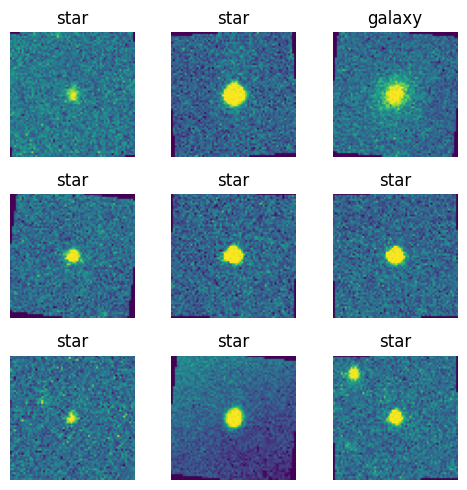

In [5]:
# Display 9 sample images
plt.figure(figsize=(5, 5))
# Take one batch from the training loader
images, labels = next(iter(train_loader))
for i in range(min(9, images.size(0))):
    ax = plt.subplot(3, 3, i + 1)
    img = images[i].permute(1, 2, 0).numpy()
    plt.imshow(img)
    plt.title(class_names[labels[i].item()])
    plt.axis("off")
plt.tight_layout()
plt.show()

## 4. Make CNN

In [6]:
# Define the CNN model in PyTorch
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(  # Consider only input layer for grayscale
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # 3 -> 1
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Dropout(0.5),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(), # [128, 8, 8] → [128 × 8 × 8] = [8192]
            nn.Linear(128 * 8 * 8, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


model = SimpleCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

print(model)

SimpleCNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.5, inplace=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=8192, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=2, bias=True)
  )
)


## 5. Train the model

In [7]:
epochs = 20
train_losses = []
train_accuracies = []
val_accuracies = []
epoch_times = []

for epoch in range(epochs):
    epoch_start = time.time()

    model.train()
    running_loss = 0.0
    running_correct = 0
    total = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        running_correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total if total > 0 else 0
    train_acc = running_correct / total if total > 0 else 0

    # Validation
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
    val_acc = val_correct / val_total if val_total > 0 else 0

    epoch_time = time.time() - epoch_start
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    epoch_times.append(epoch_time)

    print(
        f"Epoch {epoch+1}/{epochs} - "
        f"Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f}, "
        f"Val acc: {val_acc:.4f}, Time: {epoch_time:.2f}s"
    )

total_training_time = sum(epoch_times)
print(f"Total training time: {total_training_time:.2f} seconds")

Epoch 1/20 - Train loss: 0.5551, Train acc: 0.7602, Val acc: 0.7538, Time: 2.18s
Epoch 2/20 - Train loss: 0.5274, Train acc: 0.7667, Val acc: 0.7538, Time: 1.84s
Epoch 3/20 - Train loss: 0.4870, Train acc: 0.7667, Val acc: 0.7571, Time: 1.81s
Epoch 4/20 - Train loss: 0.4306, Train acc: 0.7921, Val acc: 0.7856, Time: 2.01s
Epoch 5/20 - Train loss: 0.3922, Train acc: 0.8197, Val acc: 0.8325, Time: 2.08s
Epoch 6/20 - Train loss: 0.3723, Train acc: 0.8441, Val acc: 0.8291, Time: 2.18s
Epoch 7/20 - Train loss: 0.3481, Train acc: 0.8634, Val acc: 0.8258, Time: 2.28s
Epoch 8/20 - Train loss: 0.3298, Train acc: 0.8663, Val acc: 0.8476, Time: 3.05s
Epoch 9/20 - Train loss: 0.3383, Train acc: 0.8616, Val acc: 0.8543, Time: 3.16s
Epoch 10/20 - Train loss: 0.3212, Train acc: 0.8728, Val acc: 0.8610, Time: 2.54s
Epoch 11/20 - Train loss: 0.3247, Train acc: 0.8552, Val acc: 0.8744, Time: 2.20s
Epoch 12/20 - Train loss: 0.2899, Train acc: 0.8738, Val acc: 0.8727, Time: 2.18s
Epoch 13/20 - Train loss:

## 6. Evaluate on test set

In [ ]:
model.eval()
test_correct = 0
test_total = 0
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        test_correct += (preds == labels).sum().item()
        test_total += labels.size(0)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

test_acc = test_correct / test_total if test_total > 0 else 0
test_f1 = f1_score(all_labels, all_preds, average="binary")  # binary galaxy vs star
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test F1 score: {test_f1:.4f}")

Test accuracy: 0.9098
Test F1 score: 0.9448
Total training time: 47.15 seconds


## 7. Convergence

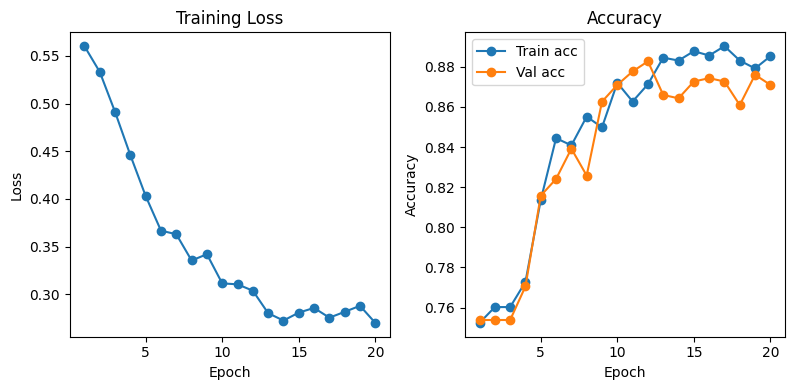

In [49]:
# Plot training/validation convergence
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(12, 4))

# Loss
plt.subplot(1, 3, 1)
plt.plot(epochs_range, train_losses, marker="o")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Accuracy
plt.subplot(1, 3, 2)
plt.plot(epochs_range, train_accuracies, marker="o", label="Train acc")
plt.plot(epochs_range, val_accuracies, marker="o", label="Val acc")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()